In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
"""
Testing environment with stable_baselines3 library
"""
import sys
sys.path.append('../')

from stable_baselines3.common.env_checker import check_env
from envs.MO_single_agent_battery_storage_env import BatteryStorageInGridEnv

env = BatteryStorageInGridEnv()

check_env(env)

100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


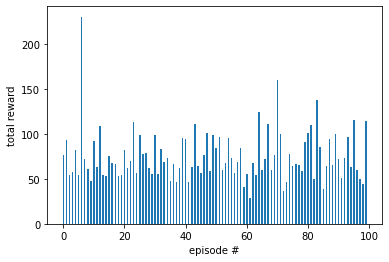

In [8]:
"""
Testing RL agent which randomly chooses actions
"""
import sys
sys.path.append('../')
from typing import List
import numpy as np
import os
import pandas as pd
import gym

from tqdm import tqdm
import matplotlib.pyplot as plt

env = BatteryStorageInGridEnv()

episodes = 100

rewards_lst_1 = []

for i in tqdm(range(episodes)):
    ob = env.reset()
    done = False
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)

    while not done:
        # random action as policy
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    # print("episode {} mean reward: {}".format(i, np.mean(rewards)))
    rewards_lst_1.append(np.sum(rewards))

# print(rewards_lst_1)
# plot episode # versus total episode reward
plt.bar(list(range(episodes)), rewards_lst_1, width=0.5)

# naming the x axis 
plt.xlabel('episode #') 
# naming the y axis 
plt.ylabel('total reward')

plt.show()

In [23]:
from stable_baselines3.ddpg.policies import MultiInputPolicy
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3 import DDPG

env = BatteryStorageInGridEnv()

# the noise objects for DDPG
# n_actions = env.action_space.shape[-1]
# action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

# model = DDPG(MultiInputPolicy, env, action_noise=action_noise, verbose=1)
model = DDPG(MultiInputPolicy, env, verbose=1)
model.learn(total_timesteps=200000)
model.save("ddpg_single_agent_battery_env")

# del model # remove to demonstrate saving and loading

model = DDPG.load("ddpg_single_agent_battery_env")

episodes = 100

rewards_lst_2 = []

for i in tqdm(range(episodes)):
    obs = env.reset()
    done = False
    start = True
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
    avg = np.zeros(1)
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    rewards_lst_2.append(np.sum(rewards))

# plot episode # versus total episode reward
plt.bar(list(range(episodes)), rewards_lst_2)

# naming the x axis 
plt.xlabel('episode #') 
# naming the y axis 
plt.ylabel('total reward')

plt.show()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


AssertionError: 

100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


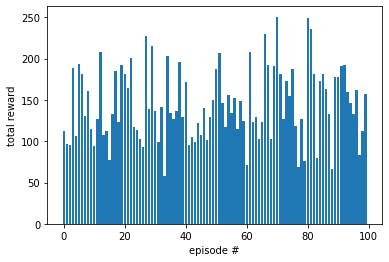

In [21]:
from stable_baselines3 import PPO

env = BatteryStorageInGridEnv()

# model = PPO("MultiInputPolicy", env, verbose=1)
# model.learn(total_timesteps=200000)
# model.save("ppo_single_agent_battery_env")

# del model # remove to demonstrate saving and loading

model = PPO.load("ppo_single_agent_battery_env")

episodes = 100

rewards_lst_4 = []

for i in tqdm(range(episodes)):
    obs = env.reset()
    done = False
    start = True
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
    avg = np.zeros(1)
    while not done:
        action, _states = model.predict(obs)
        if action.shape[0] == 1:
            action = action.reshape((2,))
        obs, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    rewards_lst_4.append(np.sum(rewards))

# plot episode # versus total episode reward
plt.bar(list(range(episodes)), rewards_lst_4)

# naming the x axis 
plt.xlabel('episode #') 
# naming the y axis 
plt.ylabel('total reward')

plt.show()